In [1]:
import casadi as ca
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.spatial import ConvexHull
from scipy.linalg import sqrtm, inv

In [2]:
nu = 2
N_Sam = 10

In [3]:
random_vals = np.random.uniform(-1, 1, size=(nu,N_Sam))
print(random_vals)

[[ 0.99263585 -0.48698535 -0.30217184  0.87817839  0.26946931  0.58325657
  -0.95884335 -0.84580566 -0.83439235 -0.30051595]
 [ 0.17182332 -0.22441461  0.02295367  0.24023304  0.25914612 -0.05196495
  -0.77710444  0.38419883  0.83920853 -0.01510533]]


In [4]:
data_id = "08"
background_filepath = f"../data/{data_id}_background.png"
recordingMeta_filepath = f"../data/{data_id}_recordingMeta.csv"
tracks_filepath = f"../data/{data_id}_tracks.csv"
tracksMeta_filepath = f"../data/{data_id}_tracksMeta.csv"
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 44]
xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
random_vals = np.vstack((xAcc,yAcc))
N_Sam = random_vals.shape[1]
print(type(random_vals))
postion_init = np.array([[64], [-2], [-19], [-2]])

<class 'numpy.ndarray'>


In [5]:
def opti_SDP_ca():   
    opti = ca.Opti()

    A = opti.variable(nu,nu)
    b = opti.variable(nu,1)

    samples = opti.parameter(nu,N_Sam)

    opti.minimize(ca.log(ca.det(ca.inv(A))))

    for i in range(N_Sam):
        opti.subject_to(ca.norm_2(A@samples[:,i]+b)**2<=1)

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f',[samples],[A,b])

In [6]:
def opti_SDP(nu,N_Sam,samples):
    A = cp.Variable((nu, nu), PSD=True)
    b = cp.Variable((nu, 1))
    constraints = [A - 1e-8*np.eye(nu) >> 0]
    for i in range(N_Sam):
        constraints += [cp.norm(A@cp.reshape(samples[:,i], (2, 1),order='F') + b, 2) <= 1]
    objective = cp.Maximize(cp.log_det(A))

    problem = cp.Problem(objective, constraints)
    problem.solve(solver = cp.SCS) # verbose=True

    return A.value, b.value

In [7]:
A_hat, b_hat = opti_SDP(nu,N_Sam,random_vals)
print(A_hat)
print(b_hat)

[[ 0.4086113  -0.15948792]
 [-0.15948792  0.82305246]]
[[-0.15973034]
 [-0.69444677]]


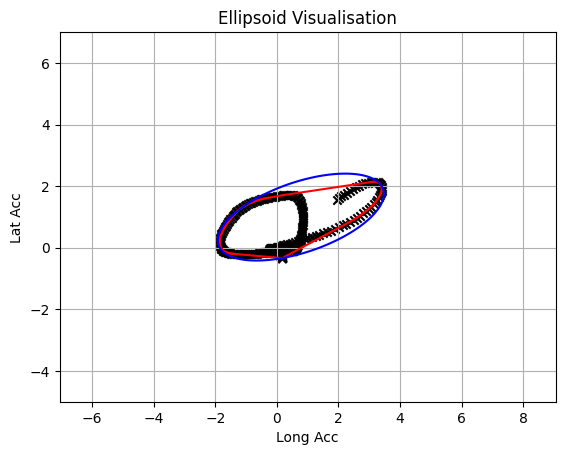

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the matrix A and vector b for the 2D ellipsoid
A = A_hat
b = b_hat

# Create a grid of points (u, v) in the plane
u_range = np.linspace(-5, 7, 400)
v_range = np.linspace(-5, 7, 400)
u, v = np.meshgrid(u_range, v_range)

# Vectorize u and v to apply the transformation
uv = np.vstack([u.flatten(), v.flatten()]).T

# Apply the transformation A*u + b
transformed_uv = np.dot(uv, A.T) + b.T

# Compute the quadratic form ||A*u + b||^2
quad_form = np.sum(transformed_uv**2, axis=1)

# Reshape to match the grid shape
quad_form = quad_form.reshape(u.shape)

points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

# Plot the 2D ellipsoid using contour plot
plt.contour(u, v, quad_form, levels=[1], colors='b')  # Level set at 1
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')
plt.title("Ellipsoid Visualisation")
plt.xlabel('Long Acc')
plt.ylabel('Lat Acc')
plt.axis('equal')
plt.grid(True)
plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


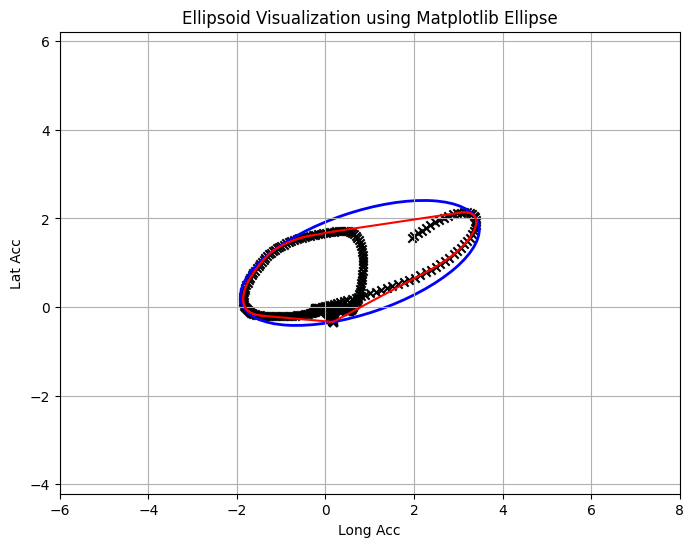

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.spatial import ConvexHull

# Define the matrix A and vector b for the 2D ellipsoid
A = A_hat  # Replace with your actual A_hat
b = b_hat  # Replace with your actual b_hat

# Generate random points (replace with your actual data)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the convex hull of random points
points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

# Plot the random points
plt.scatter(random_vals[0,:], random_vals[1,:], marker='x', color='black')

# Compute the ellipse parameters from A and b
# The ellipsoid is defined by (x - c)^T Q^{-1} (x - c) = 1
# Where Q = (A^T A)^{-1} and c = -A^{-1}b

# Compute Q = (A^T A)^{-1}
Q = np.linalg.inv(A.T @ A)

# Compute center c = -A^{-1}b
c = -np.linalg.solve(A, b)

# Compute eigenvalues and eigenvectors of Q
vals, vecs = np.linalg.eigh(Q)

# Get the ellipse parameters
width = 2 * np.sqrt(vals[0])  # Major axis
height = 2 * np.sqrt(vals[1])  # Minor axis
angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))  # Rotation angle

# Create and add the ellipse
ellipse = Ellipse(xy=c, width=width, height=height, angle=angle,
                 edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse)

# Set plot properties
plt.title("Ellipsoid Visualization using Matplotlib Ellipse")
plt.xlabel('Long Acc')
plt.ylabel('Lat Acc')
plt.axis('equal')
plt.grid(True)

# Adjust plot limits to show everything
plt.xlim(min(u_range.min(), points[:,0].min())-1, max(u_range.max(), points[:,0].max())+1)
plt.ylim(min(v_range.min(), points[:,1].min())-1, max(v_range.max(), points[:,1].max())+1)

plt.show()

In [10]:
T = 0.25
A_SV = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
B_SV = np.array([[0.5*T**2, 0], [T, 0], [0, 0.5*T**2], [0, T]])

Q = np.linalg.inv(A_hat.T@A_hat)
Q_sqrt = np.linalg.cholesky(Q)
bar_u = -Q@A_hat.T@b_hat

In [11]:
print(Q_sqrt)
print(Q)
print(Q_sqrt.T@Q_sqrt)

[[2.69680823 0.        ]
 [0.75371349 1.19280139]]
[[7.27277461 2.03262075]
 [2.03262075 1.99085919]]
[[7.84085864 0.8990305 ]
 [0.8990305  1.42277515]]


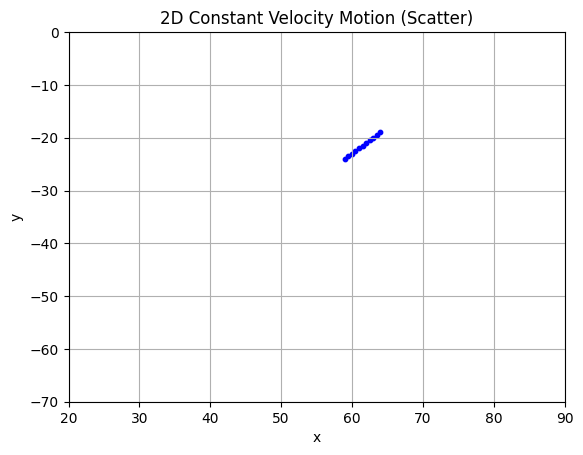

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_ellipsoid(A_hat, b_hat, ratio):
    # Convert from ||A*x + b|| <= 1 to standard form (x-c)^T Q (x-c) <= 1
    # where Q = A^T A and c = -A^{-1}b
    Q = A_hat.T @ A_hat
    c = -np.linalg.inv(A_hat) @ b_hat
    
    # Get eigenvalues and eigenvectors of Q
    eigvals, eigvecs = np.linalg.eigh(Q)
    radii = 1 / np.sqrt(eigvals)  # Semi-axis lengths
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))  # Rotation angle
    
    # Create and add the ellipse
    ellipse = Ellipse(c.flatten(), ratio * radii[0], ratio * radii[1], angle=angle,
                      alpha=0.3, fill=True)
    plt.gca().add_patch(ellipse)
    
    return ellipse

fig, ax = plt.subplots()

T = 0.25
A = np.array([
    [1, T, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, T],
    [0, 0, 0, 1]
])
x = postion_init

trajectory = [x.copy()]
for i in range(10):
    x = A @ x
    plot_ellipsoid(A_hat, b_hat,i)
    trajectory.append(x.copy())

trajectory = np.hstack(trajectory)
x_vals = trajectory[0]
y_vals = trajectory[2]

ax.scatter(x_vals, y_vals, s=10, c='blue')  # s sets the marker size
ax.set_xlim([20, 90])
ax.set_ylim([-70, 0])  # flip y-axis as intended
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('2D Constant Velocity Motion (Scatter)')
plt.grid()
plt.show()


In [13]:
def opti_SDP_lemma1(nu, sample, A_pre, b_pre):
    # Define variables
    B = cp.Variable((nu, nu), PSD=True)
    b_tilde = cp.Variable((nu, 1))
    tau1 = cp.Variable((1, 1))
    tau2 = cp.Variable((1, 1))
    tau = [tau1, tau2]

    # Parameters
    A = A_pre
    b = b_pre
    sample = cp.reshape(sample, (2, 1))

    # Define G, g, and c
    G1 = A.T @ A
    g1 = (A @ b).T
    c1 = b.T @ b - 1
    G2 = np.identity(2)
    g2 = -sample.T
    c2 = (sample.T @ sample) - 1e-8
    G = [G1, G2]
    g = [g1, g2]
    c = [c1, c2]

    # Constraints for tau
    constraints = [tau1 >= 0, tau2 >= 0]

    # Loop to create the block matrix constraints
    for i in range(2):
        tmp1 = cp.reshape(B - tau[i] * G[i], (2, 2), order='C')  # Specify order 'C' to suppress the warning
        tmp2 = cp.reshape(b_tilde - tau[i] * (g[i].T), (2, 1), order='C')
        tmp3 = cp.reshape(-1 - tau[i] - c[i], (1, 1), order='C')
        zeros = cp.Constant(np.zeros((2, 2)))  # Explicit constant for zeros

        # Construct the block matrix using cp.bmat
        tmp_matrix = cp.bmat([
            [tmp1, tmp2, zeros],
            [tmp2.T, tmp3, b_tilde.T],
            [zeros, b_tilde, -B],
        ])
        
        # Add the semidefinite constraint
        constraints += [tmp_matrix << 0]

    # Objective function
    objective = cp.Maximize(cp.log_det(B))

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)

    return B.value, b_tilde.value

In [14]:
def opti_SDP_lemma(nu, A_last, b_last, c_last, u_last): 
    B         = cp.Variable((nu, nu), PSD=True) # B = A**2
    tau       = cp.Variable( )
    tau_u     = cp.Variable( )
    b_tilde   = cp.Variable((nu, 1)) # b_tilde = A@b

    A_u = np.eye(nu)
    b_u = -u_last.reshape(2, 1)
    c_u = u_last.T@u_last - 1e-8

    zero_block = np.zeros((nu, nu))
    
    M  = cp.bmat([[B - tau * A_last, b_tilde - tau * b_last, zero_block],
                    [(b_tilde - tau * b_last).T, cp.reshape(-1 - tau * c_last, (1, 1),order='F'), b_tilde.T],
                    [zero_block, b_tilde, -B]])
    Mu = cp.bmat([[B - tau_u * A_u, b_tilde - tau_u * b_u, zero_block],
                    [(b_tilde - tau_u * b_u).T, cp.reshape(-1 - tau_u * c_u, (1, 1),order='F'), b_tilde.T],
                    [zero_block, b_tilde, -B]])
    
    constraints = [tau >= 0, tau_u >= 0, -M >> 0, -Mu >> 0, B - 1e-8*np.eye(nu) >> 0]  
    objective   = cp.Maximize(cp.log_det(B))
    problem     = cp.Problem(objective, constraints)
    problem.solve(solver = cp.SCS)

    return B.value, b_tilde.value

In [15]:
def plot_el(A,b,i):
    u_range = np.linspace(-7, 7, 400)
    v_range = np.linspace(-7, 7, 400)
    u, v = np.meshgrid(u_range, v_range)

    # Vectorize u and v to apply the transformation
    uv = np.vstack([u.flatten(), v.flatten()]).T

    # Apply the transformation A*u + b
    transformed_uv = np.dot(uv, A.T) + b.T

    # Compute the quadratic form ||A*u + b||^2
    quad_form = np.sum(transformed_uv**2, axis=1)

    # Reshape to match the grid shape
    quad_form = quad_form.reshape(u.shape)

    # Plot the 2D ellipsoid using contour plot
    plt.contour(u, v, quad_form, levels=[1], colors='b')  # Level set at 1
    plt.scatter(random_vals[0,:i],random_vals[1,:i],marker='x',color = 'black')
    plt.title("Ellipsoid Visualisation")
    plt.xlabel('Long Acc')
    plt.ylabel('Lat Acc')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [16]:
A_init = np.array([[5, 0], 
              [0, 5]])
b_init = np.array([[0], 
              [0]]) 
c_init = b_init.T@b_init-1

(2, 2)
(2, 1)


/Users/qdzhou/CourseWork/FYP/fyp_env/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


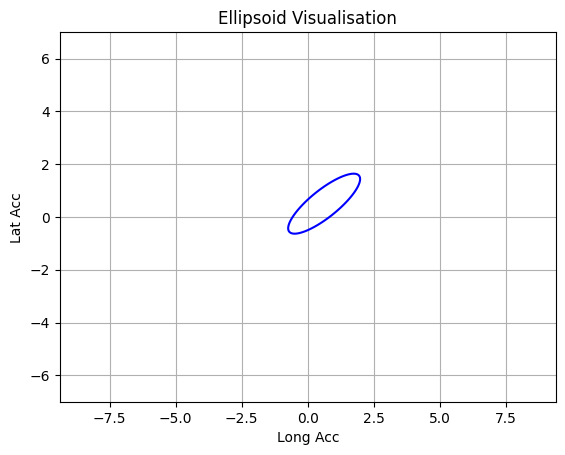

(2, 2)
(2, 1)


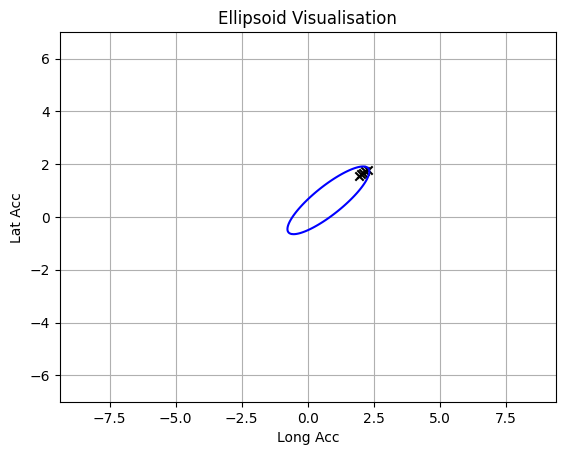

(2, 2)
(2, 1)


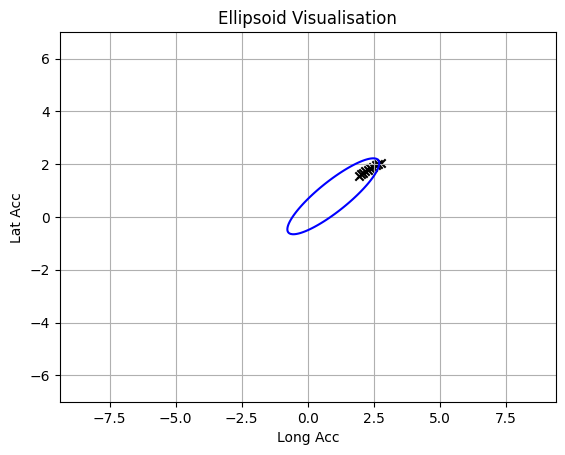

(2, 2)
(2, 1)


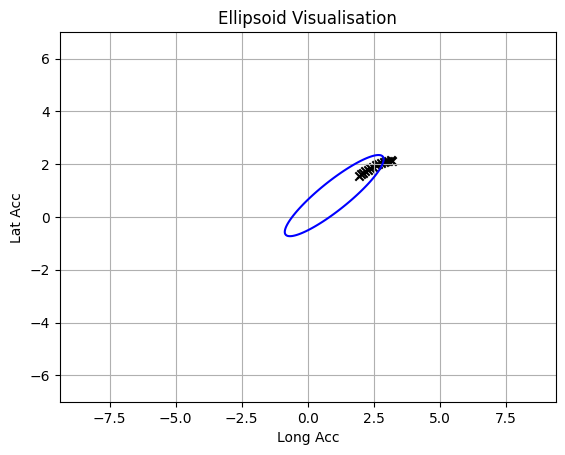

(2, 2)
(2, 1)


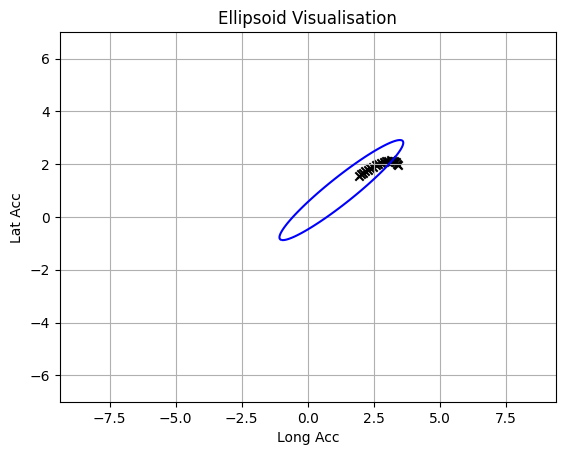

(2, 2)
(2, 1)


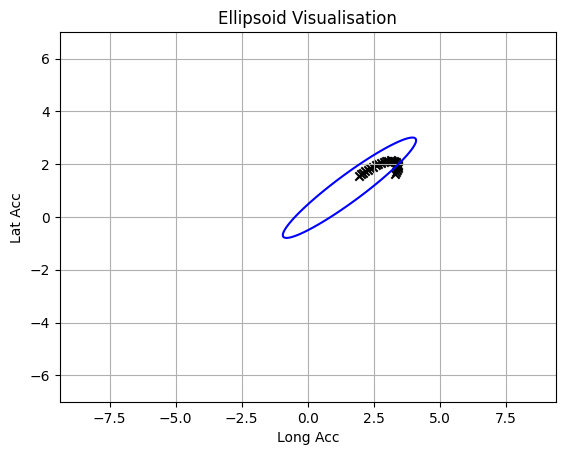

(2, 2)
(2, 1)


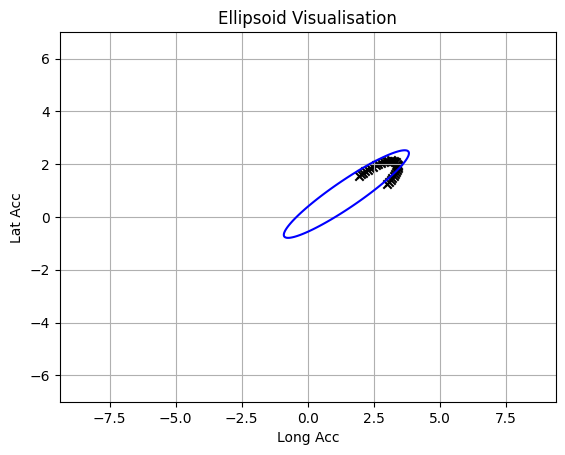

(2, 2)
(2, 1)


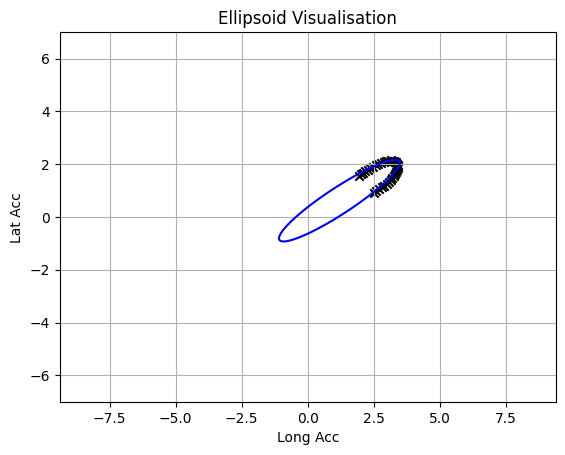

(2, 2)
(2, 1)


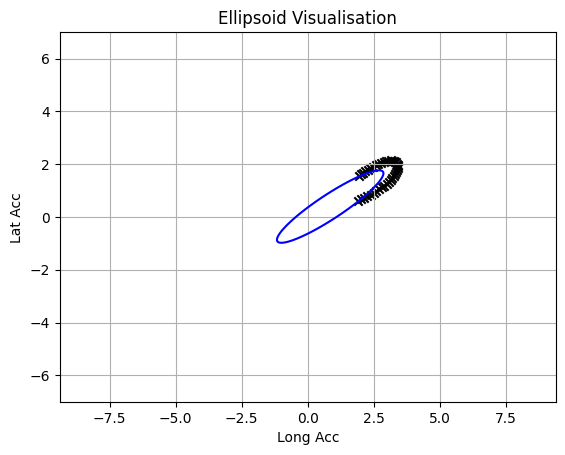

(2, 2)
(2, 1)


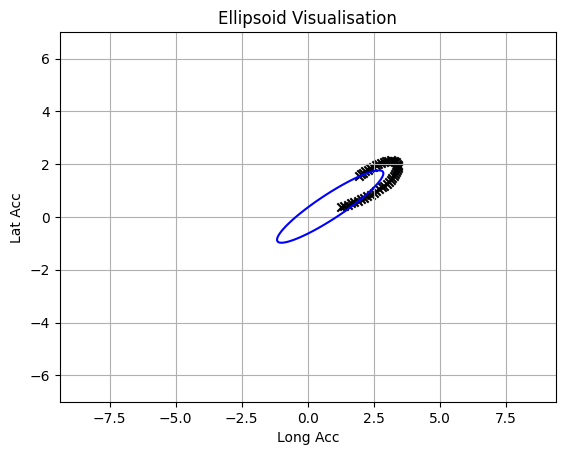

(2, 2)
(2, 1)


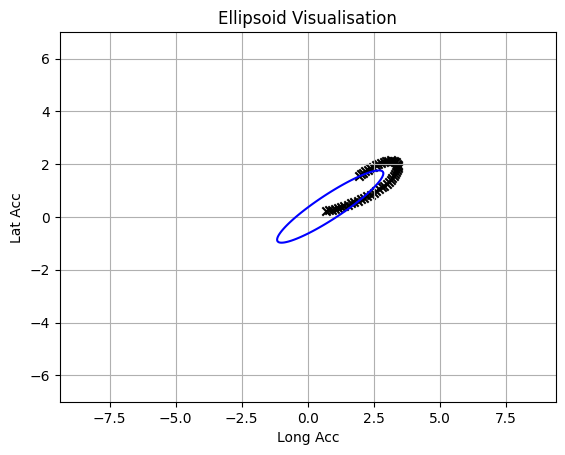

(2, 2)
(2, 1)


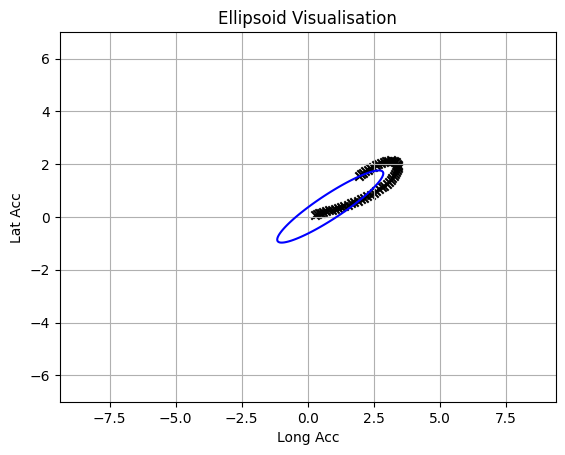

(2, 2)
(2, 1)


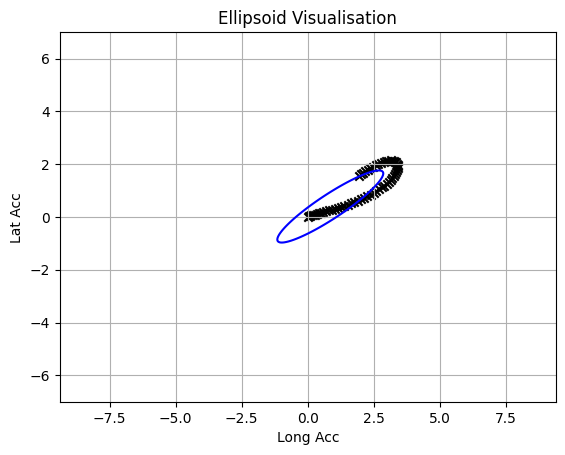

(2, 2)
(2, 1)


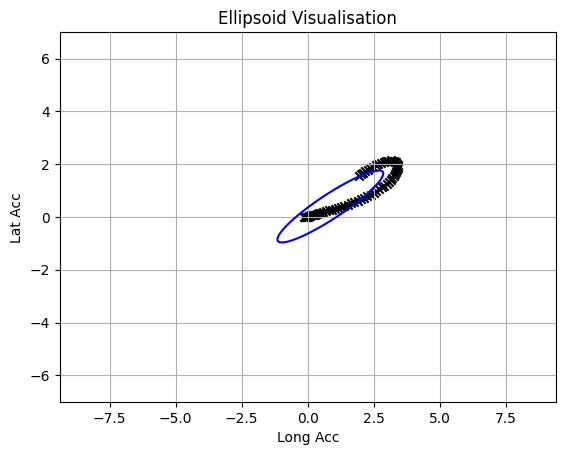

(2, 2)
(2, 1)


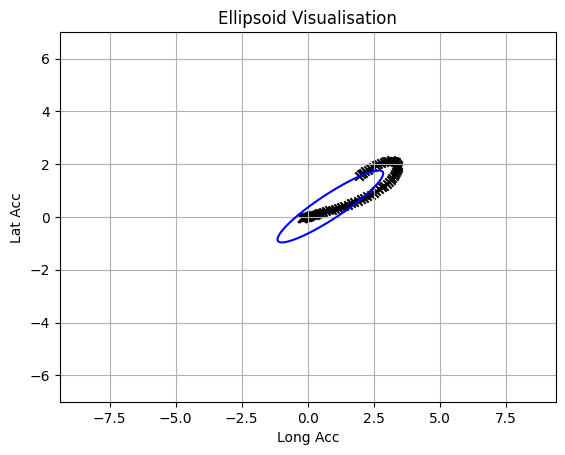

(2, 2)
(2, 1)


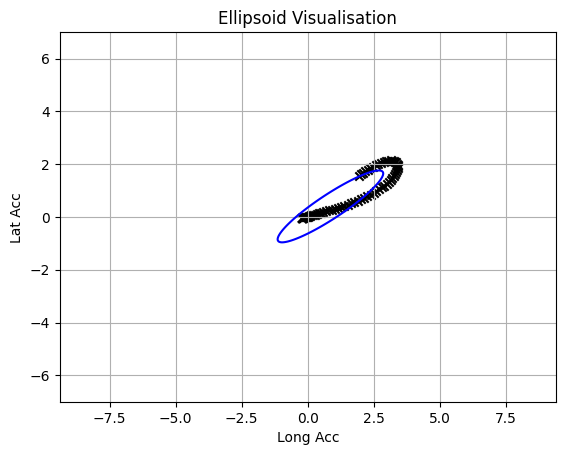

(2, 2)
(2, 1)


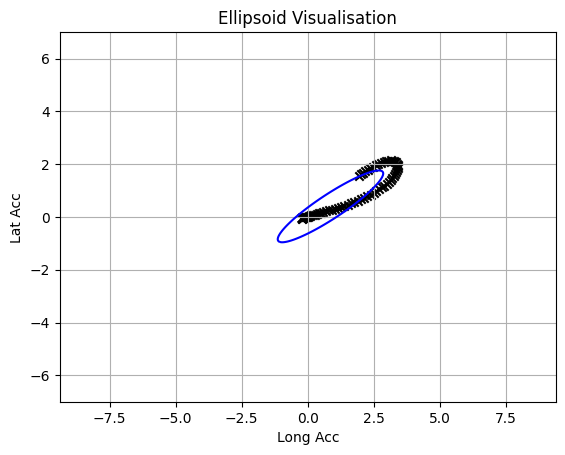

(2, 2)
(2, 1)


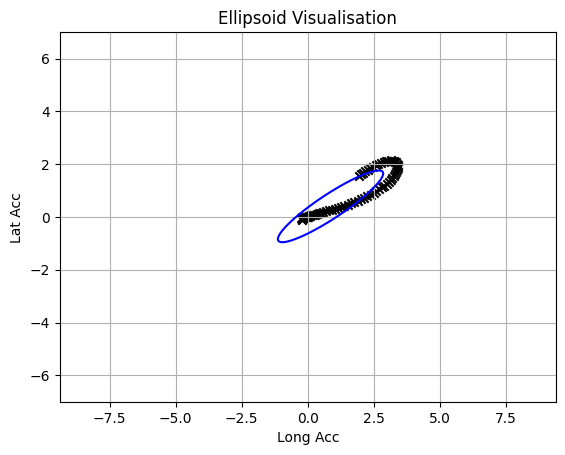

(2, 2)
(2, 1)


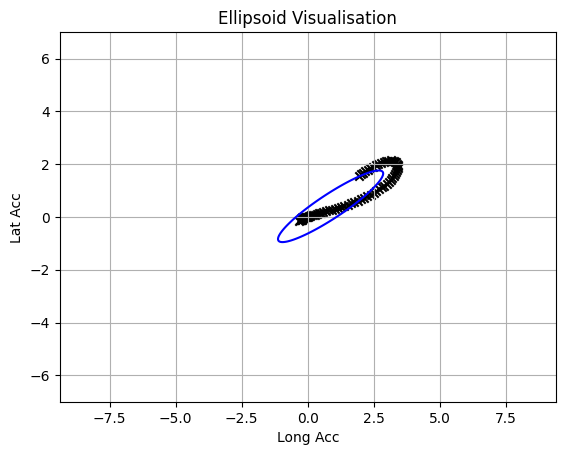

(2, 2)
(2, 1)


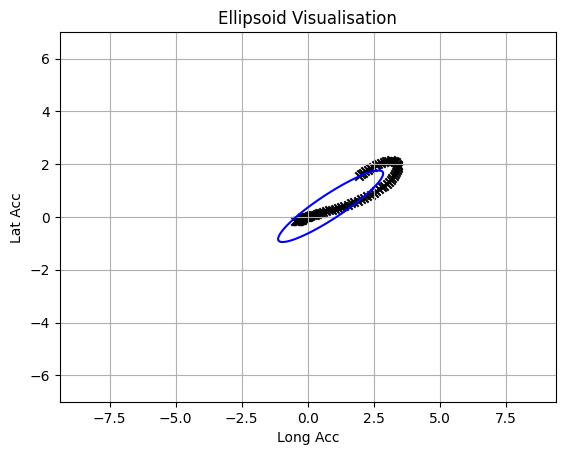

(2, 2)
(2, 1)


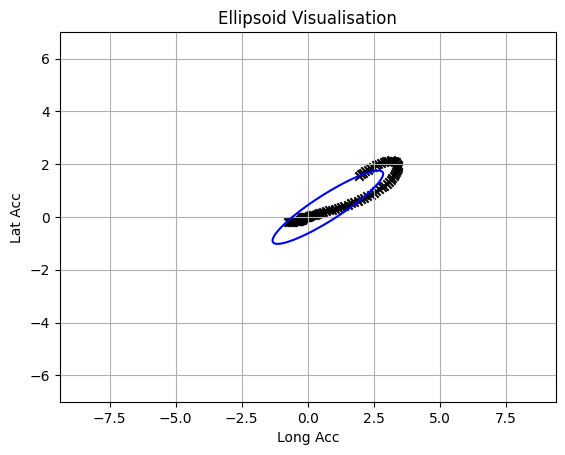

(2, 2)
(2, 1)


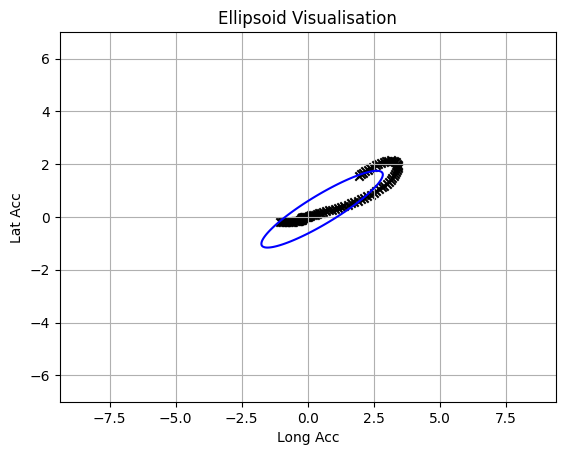

(2, 2)
(2, 1)


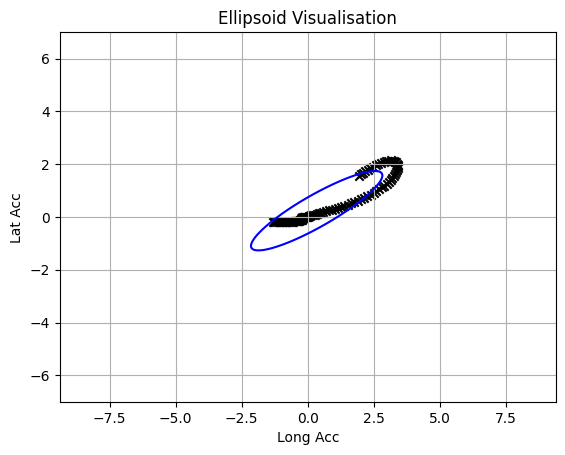

(2, 2)
(2, 1)


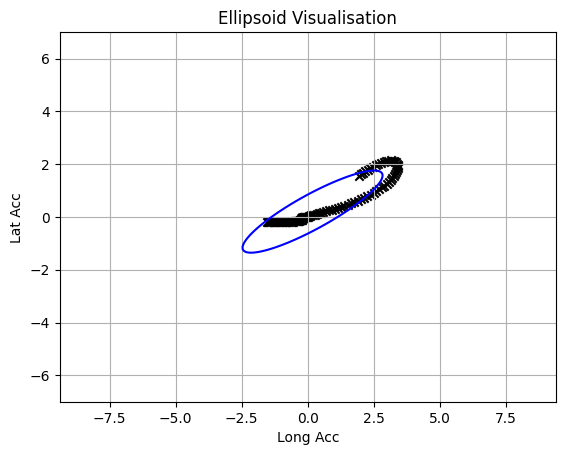

(2, 2)
(2, 1)


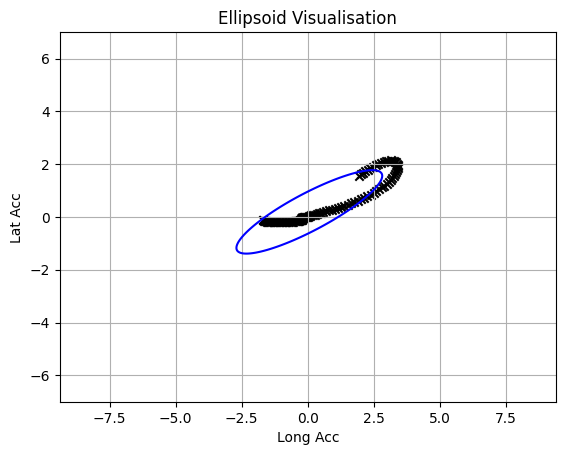

(2, 2)
(2, 1)


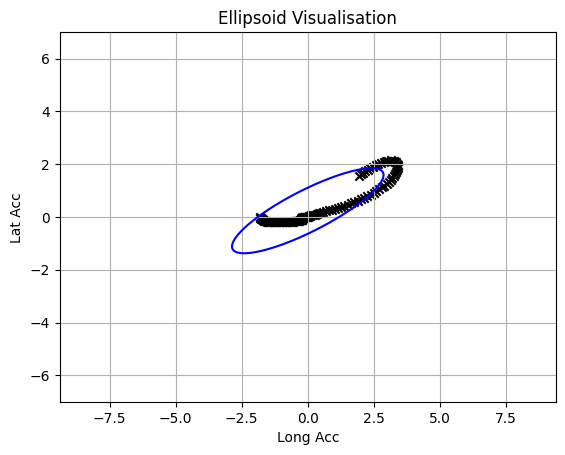

(2, 2)
(2, 1)


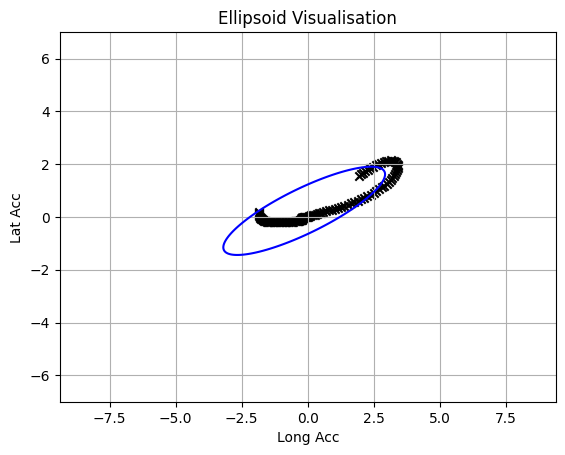

(2, 2)
(2, 1)


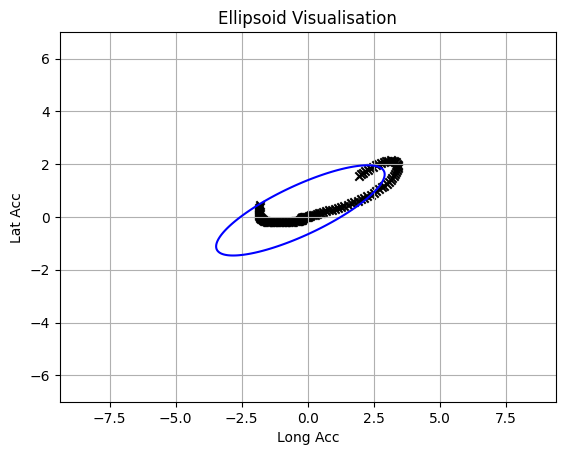

(2, 2)
(2, 1)


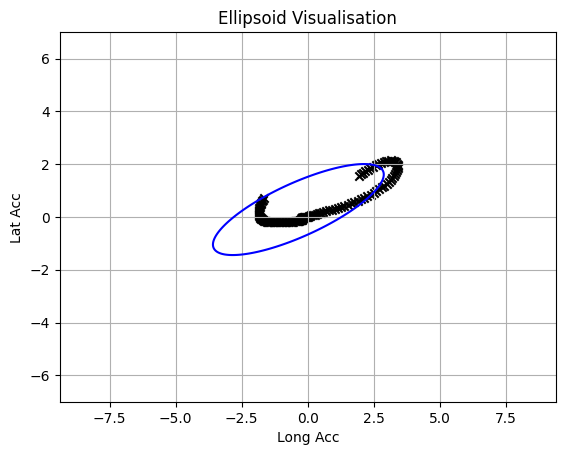

(2, 2)
(2, 1)


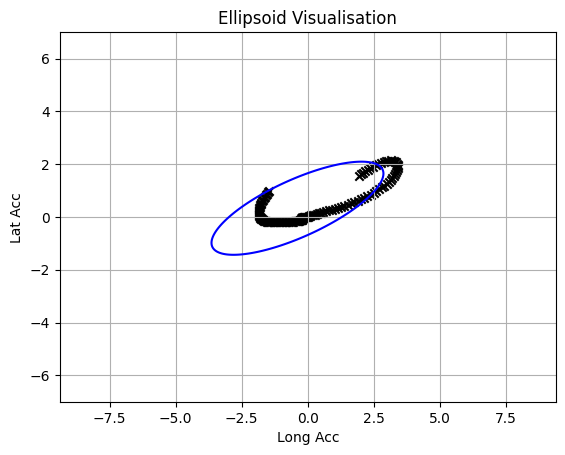

(2, 2)
(2, 1)


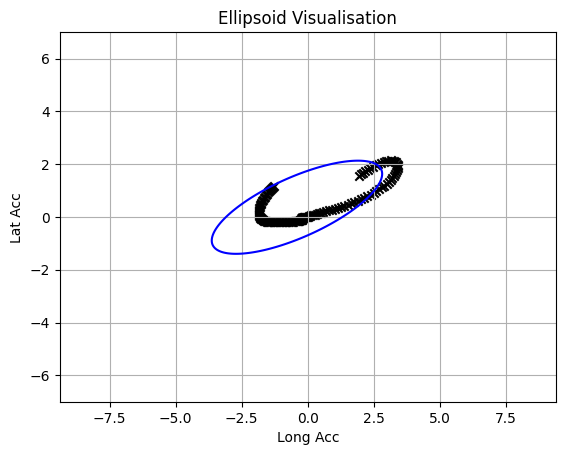

(2, 2)
(2, 1)


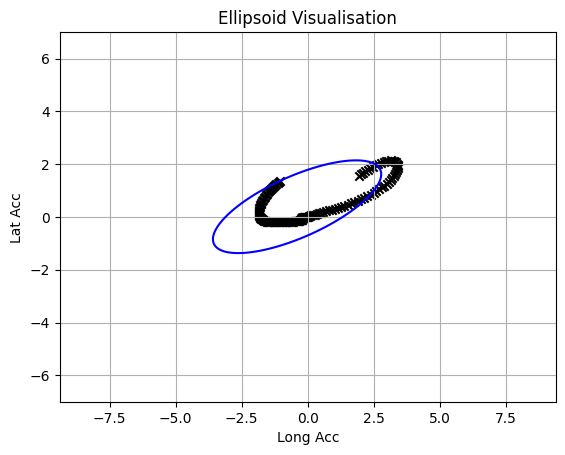

(2, 2)
(2, 1)


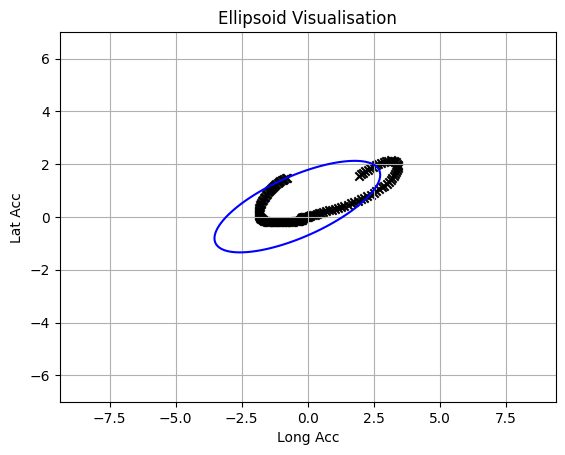

(2, 2)
(2, 1)


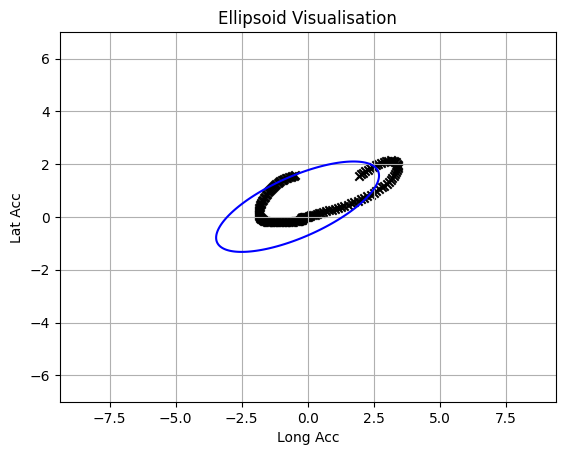

(2, 2)
(2, 1)


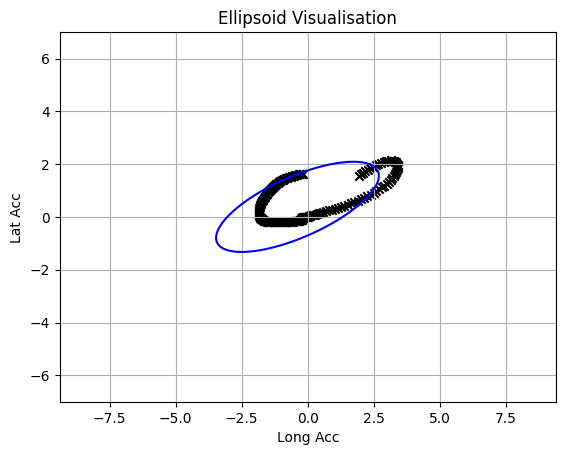

(2, 2)
(2, 1)


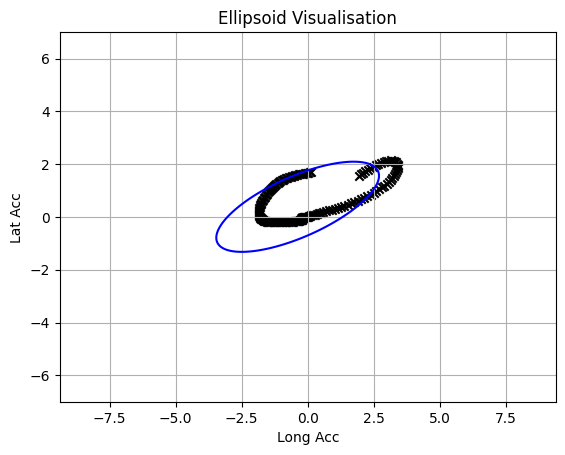

(2, 2)
(2, 1)


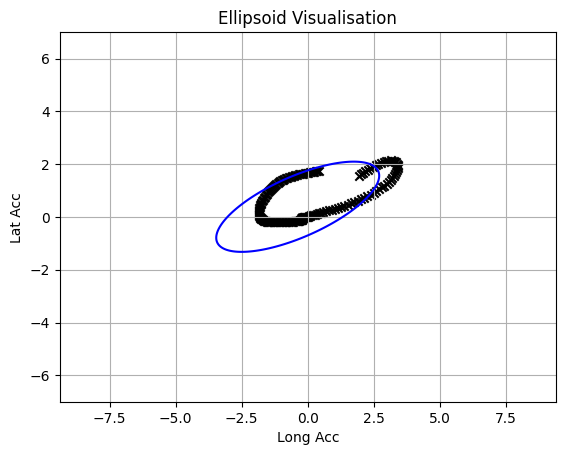

(2, 2)
(2, 1)


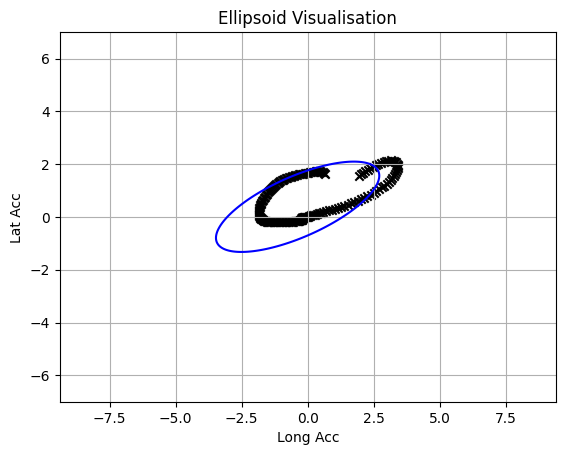

(2, 2)
(2, 1)


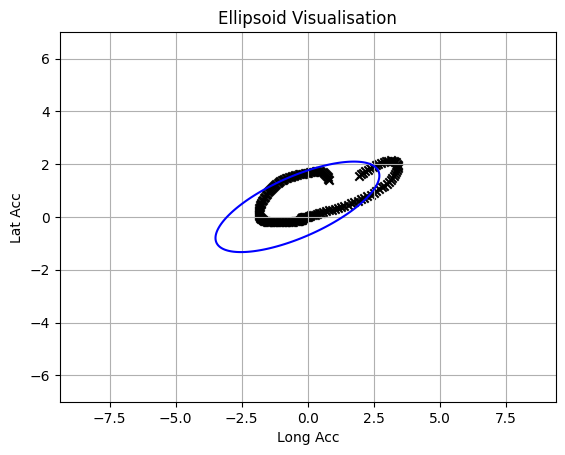

(2, 2)
(2, 1)


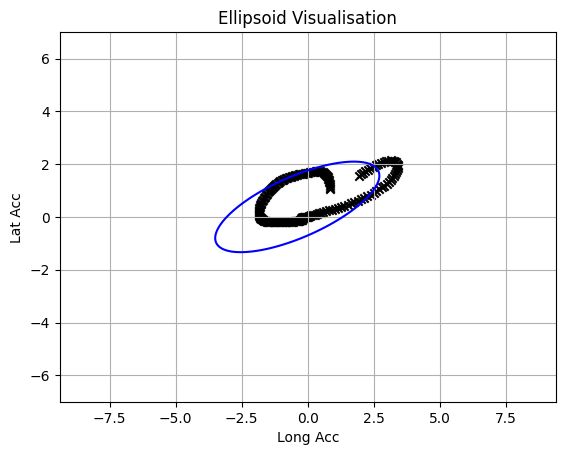

(2, 2)
(2, 1)


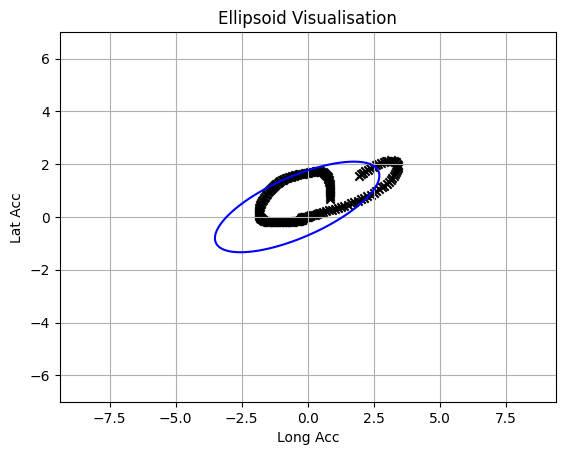

(2, 2)
(2, 1)


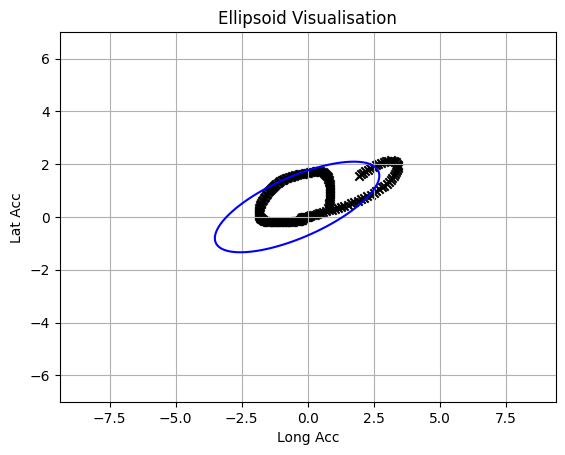

(2, 2)
(2, 1)


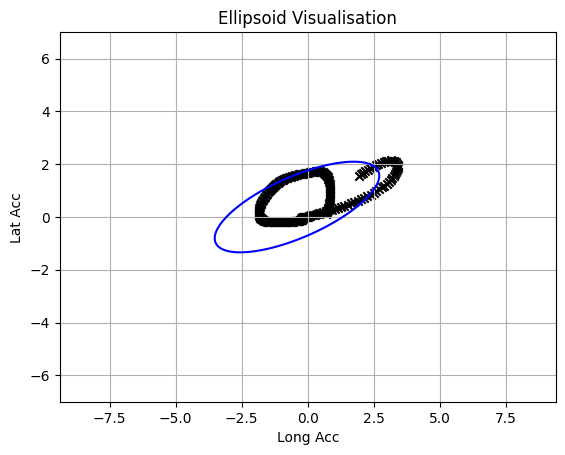

(2, 2)
(2, 1)


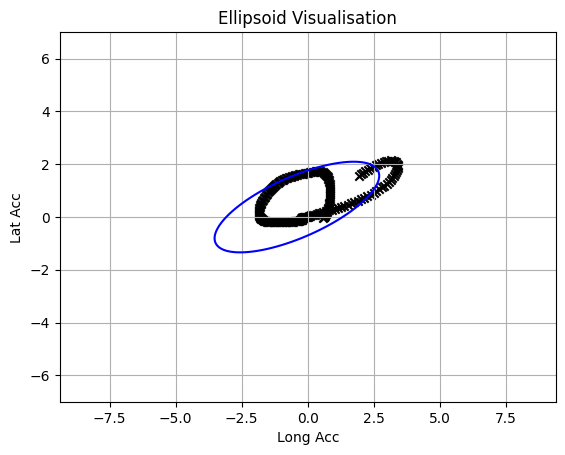

(2, 2)
(2, 1)


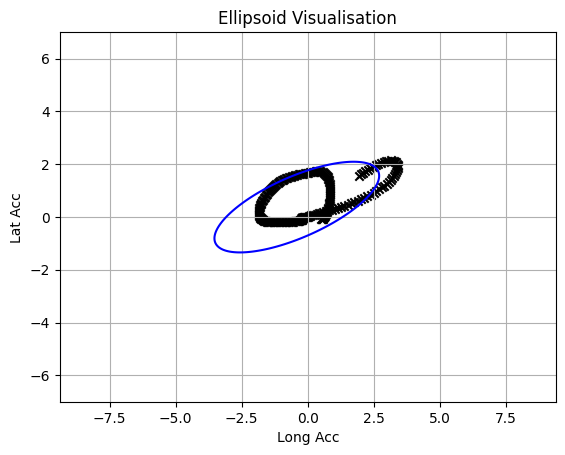

(2, 2)
(2, 1)


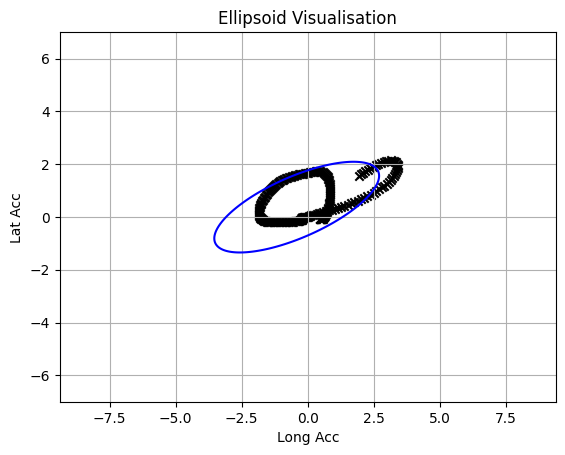

(2, 2)
(2, 1)


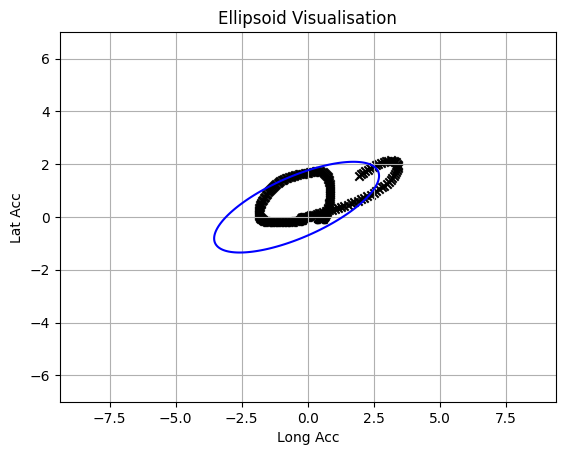

(2, 2)
(2, 1)


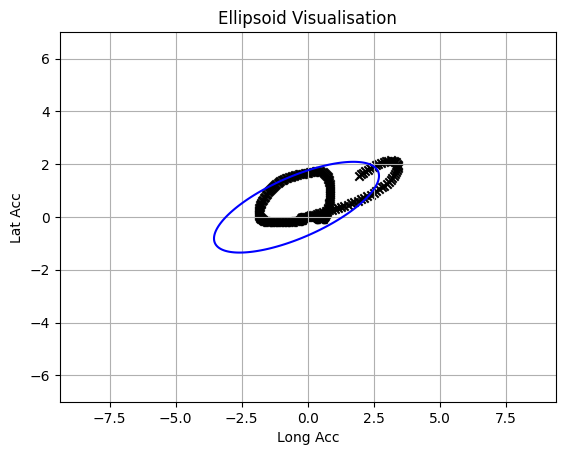

(2, 2)
(2, 1)


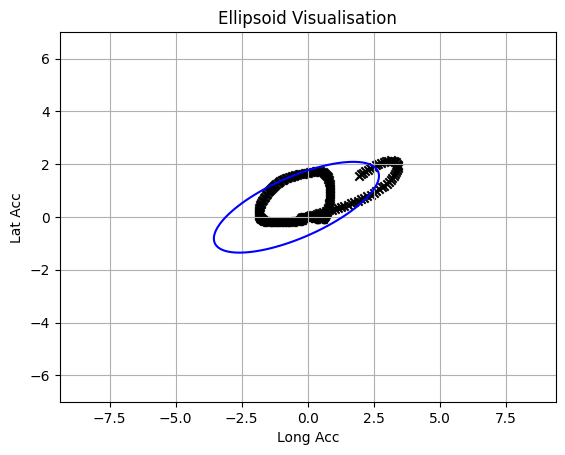

(2, 2)
(2, 1)


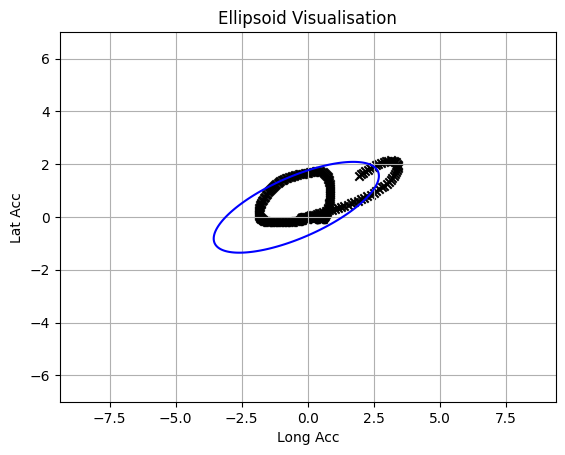

(2, 2)
(2, 1)


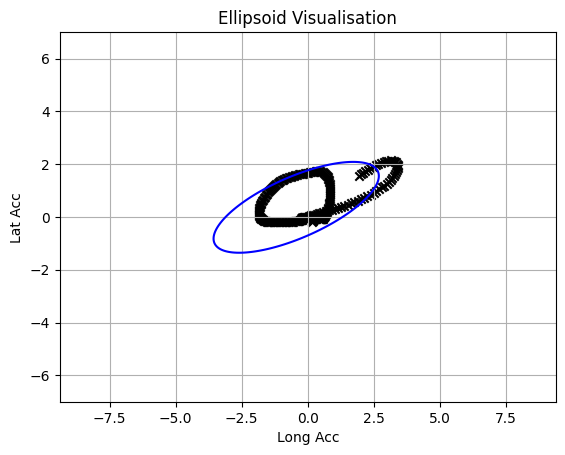

(2, 2)
(2, 1)


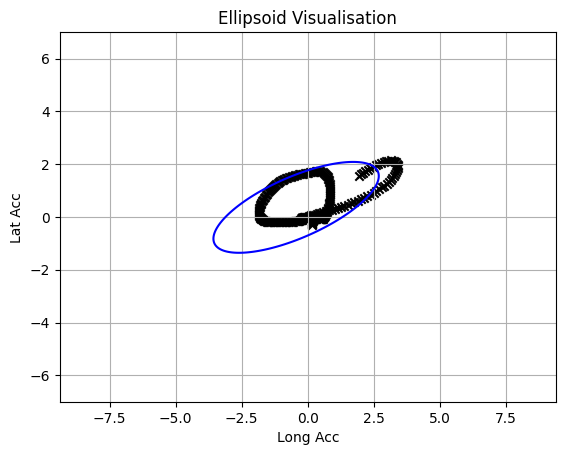

(2, 2)
(2, 1)


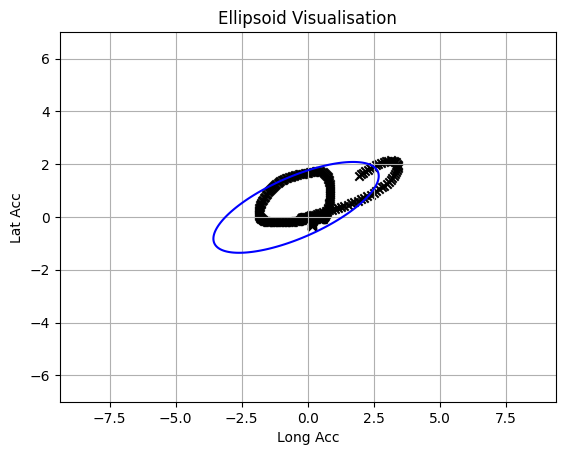

(2, 2)
(2, 1)


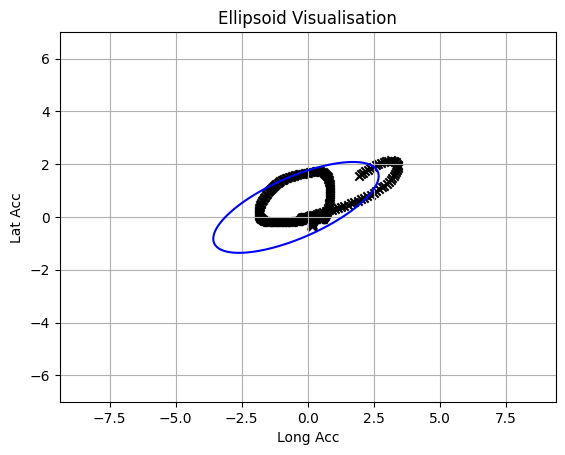

(2, 2)
(2, 1)


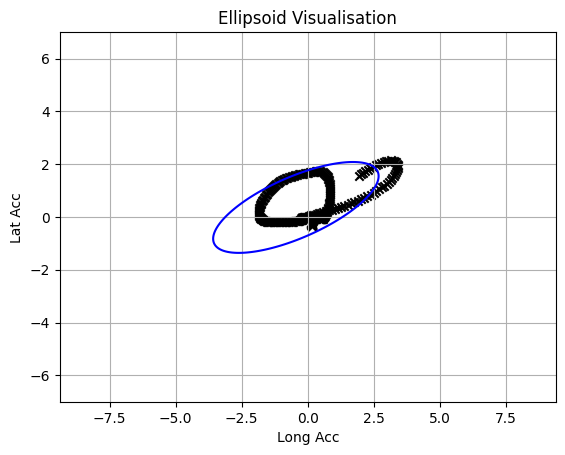

(2, 2)
(2, 1)


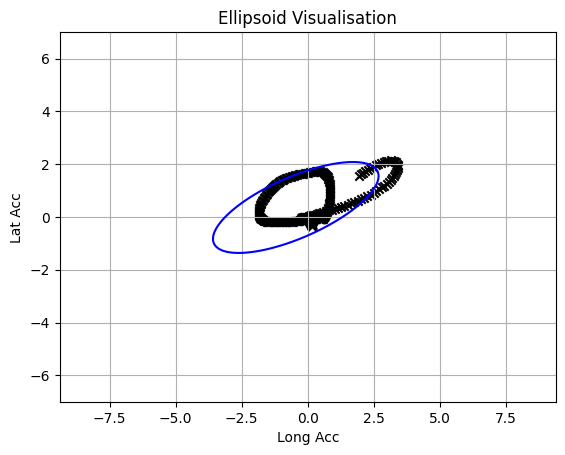

(2, 2)
(2, 1)


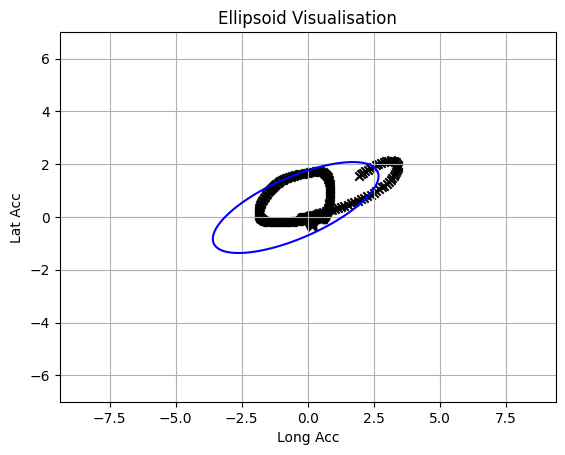

(2, 2)
(2, 1)


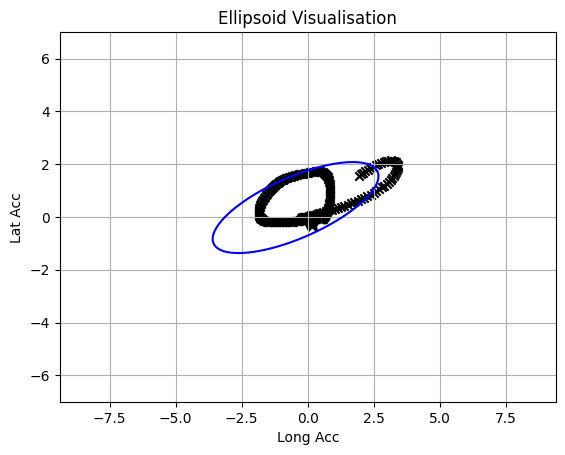

(2, 2)
(2, 1)


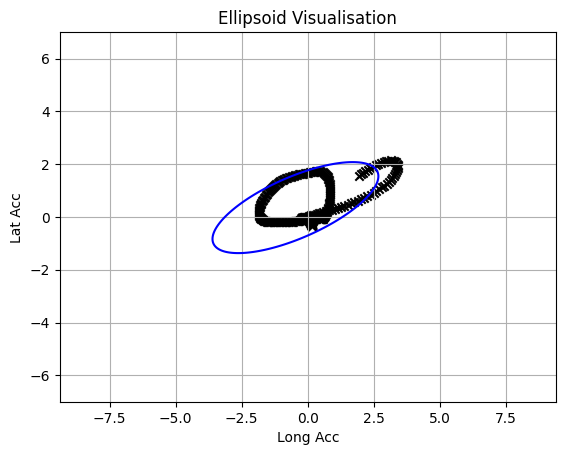

(2, 2)
(2, 1)


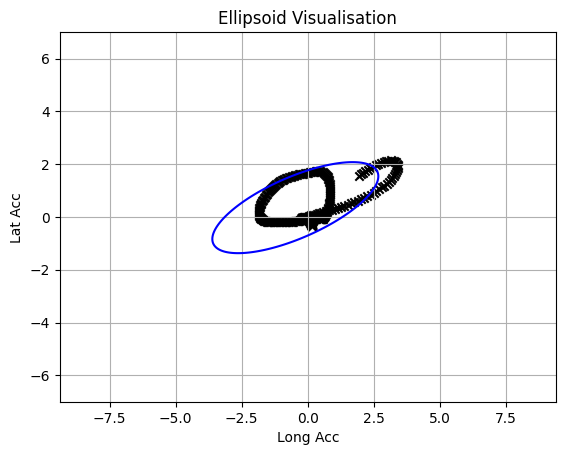

(2, 2)
(2, 1)


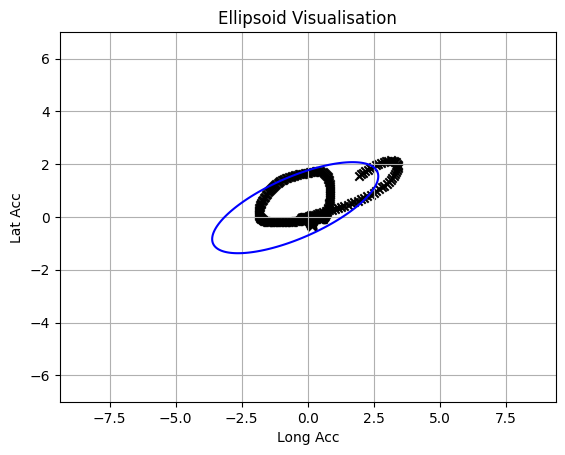

(2, 2)
(2, 1)


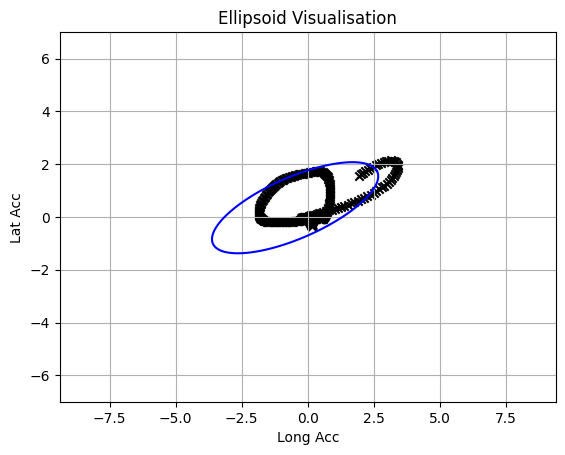

(2, 2)
(2, 1)


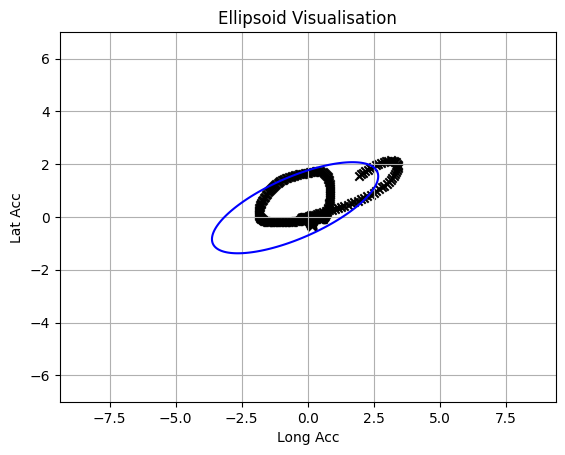

In [17]:
u_init = np.array([0.4,0.4])
B_pre, b_tilde_pre = opti_SDP_lemma(nu,A_init,b_init,c_init,u_init)
A_pre = sqrtm(B_pre)
b_pre = np.linalg.inv(A_pre)@b_tilde_pre

for i in range(N_Sam):
    A_last = A_pre.T@A_pre
    b_last = A_pre.T@b_pre
    c_last = b_pre.T@b_pre-1
    u_last = np.array([[random_vals[0,i]],[random_vals[1,i]]])
    B_pre, b_tilde_pre = opti_SDP_lemma(nu,A_last,b_last,c_last,u_last)
    A_pre = sqrtm(B_pre)
    b_pre = np.linalg.inv(A_pre)@b_tilde_pre
    if i % 5 == 0 or i == N_Sam-1:
        print(A_pre.shape)
        print(b_pre.shape)
        plot_el(A_pre,b_pre,i)